# Le réchauffement climatique

Dans ce mini-projet, on va tenter de répondre à une question : des mesures de température mesurées localement au cours du dernier siècle mettent-elles en évidence un réchauffement significatif ? On va travailler pour répondre à cette question sur les relevés de température enregistrés quotidiennement depuis juin 1920 à [la station météorologique de Montélimar](https://donneespubliques.meteofrance.fr/metadonnees_publiques/fiches/fiche_26198001.pdf). (European Climate Assessment & Dataset).

On trouve dans le fichier *montelimar_temperature.dat* un fichier de données préparées avec :
- colonne 1 : date en MJD (*modified Julian Day*)
- colonne 2 : température en degrés Celsius


La première problématique à laquelle on va êtes confronté est de faire apparaître un effet faible et lent à l'échelle des données (amplitudes de fluctuations quotidiennes ou saisonnières dix fois supérieures typiquement).

Pour cela, on va donc extraire les données issues du fichier et utiliser un code permettant de répondre à nos besoins.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [29]:
# Chargement des données
data = np.loadtxt('montelimar_temperature.dat')
date_mjd, temperature = data[:, 0], data[:, 1]

# Conversion de la date MJD en années
date_annee = date_mjd / 365.25 + 1858.875

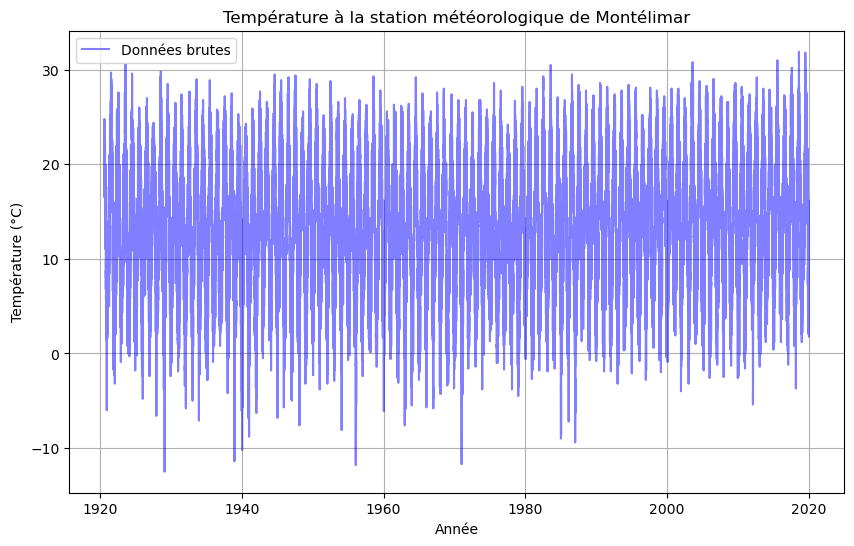

In [55]:
# Tracé des données originales et lissées
plt.figure(figsize=(10, 6))
plt.plot(date_annee, temperature, label='Données brutes', color='b', alpha=0.5)
plt.xlabel('Année')
plt.ylabel('Température (°C)')
plt.title('Température à la station météorologique de Montélimar')
plt.legend()
plt.grid(True)
plt.show()

Nous avons réussi à faire un graphique à partir des données recueillit, dans l'idéal, il aurait fallut créer une fonction qui calculerait la moyenne de température pour chaque année afin d'en faire une courbe, alors on aurait repondu à la parie qui nous demande de faire apparaître un effet faible et lent à l'échelle des données. 

La seconde problématique est de montrer que l'effet observé est significatif, c'est-à-dire que cette augmentation des températures ne correspond pas à une fluctuation statistique. Pour cela on supposera que l'erreur sur les mesures de température est de l'ordre de 5 °C. C'est l'ordre de grandeur des fluctuations quotidiennes qui ne seront pas prises en compte dans un modèle qui décrit des variations saisonnières.

Les variations saisonnières de la température peuvent être modélisée par une sinusoïde de période une année. Il faut utiliser un modèle du type sinusoïdal :

$$ T(t) = A \sin{(\omega t + \phi)} + B $$

où les paramètres $A$ (amplitude), $\phi$ (phase) et $B$ (température moyenne) doivent être ajustés aux données, alors que $\omega = 2\pi/1\text{ an}$. Cependant, un tel modèle ajusté sur l'ensemble des données ne donnera aucune augmentation moyenne de la température. On pourra par exemple essayer d'appliquer un ajustement sinusoïdal pour chaque décennie, et voir si le paramètre $B$ (température moyenne) augmente. On peut aussi affiner ce modèle en se disant que l'accroissement lent de la température est linéaire. On pourra alors utiliser un modèle de type :

$$ T(t) = A \sin{(\omega t + \phi)} + B + C t $$

où $C$ est un nouveau paramètre à ajuster, qui correspond à l'accroissement linéaire lent de la température.

On gardera aussi en tête que l'ajustement par la fonction `curve_fit` permet de calculer assez facilement l'incertitude sur les paramètres de l'ajustement. Cela nous permettra de statuer sur le caractère significatif du réchauffement.

Pour résoudre notre problème, on va donc mettre au point un code qui utilisera une représentation sinusoidale de notre problème que l'on ajustera par le biais de la fonction `curve_fit`

In [31]:
# Modèle sinusoïdal avec tendance linéaire
def modele_sin(t, A, omega, phi, B, C):
    return A * np.sin(omega * t + phi) + B + C * t

In [32]:
# Initialisation des paramètres pour l'ajustement
initial_param = (1, 2 * np.pi, 0, np.mean(temperature), 0.01)

# Ajustement du modèle aux données
popt, pcov = curve_fit(modele_sin, date_annee, temperature, p0=initial_param)

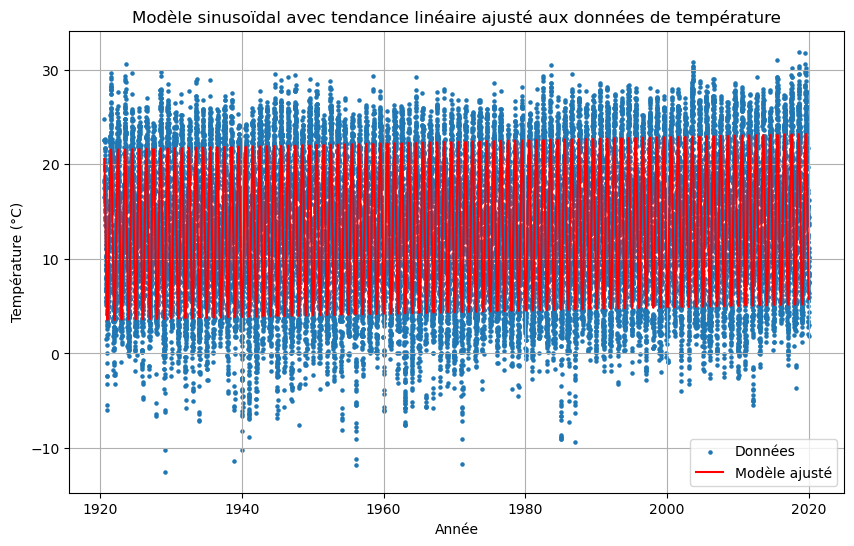

In [33]:
# Tracé des résultats
plt.figure(figsize=(10, 6))
plt.scatter(date_annee, temperature, s=5, label='Données')
plt.plot(date_annee, modele_sin(date_annee, *popt), color='red', label='Modèle ajusté')
plt.xlabel('Année')
plt.ylabel('Température (°C)')
plt.title('Modèle sinusoïdal avec tendance linéaire ajusté aux données de température')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Affichage des paramètres ajustés
print("Paramètres ajustés :", popt)

Paramètres ajustés : [ 9.00923674e+00  6.28314829e+00 -8.07993824e+00 -1.98525931e+01
  1.68608039e-02]


Désormais, on peut ajouter sur le graphique les variations saisonnières de la température qui peuvent être modélisée par une sinusoïde de période une année

In [47]:
# Modélisation des variations saisonnières avec une fonction sinusoïdale
def modele_saison(t, A, omega, phi, B):
    return A * np.sin(omega * t + phi) + B


# Modélisation de la tendance à long terme avec une fonction linéaire
def modele_lin(t, A, omega, phi, B, C):
    return A * np.sin(omega * t + phi) + B + C * t

# Initialisation des paramètres pour l'ajustement
initial_param_saison = (5, 2 * np.pi, 0, np.mean(temperature))
initial_param_lin = (*initial_param_saison, 0.01)

In [51]:
# Ajustement du modèle saisonnier aux données
popt_seasonal, pcov_seasonal = curve_fit(modele_saison, date_annee, temperature, p0=initial_param_saison)

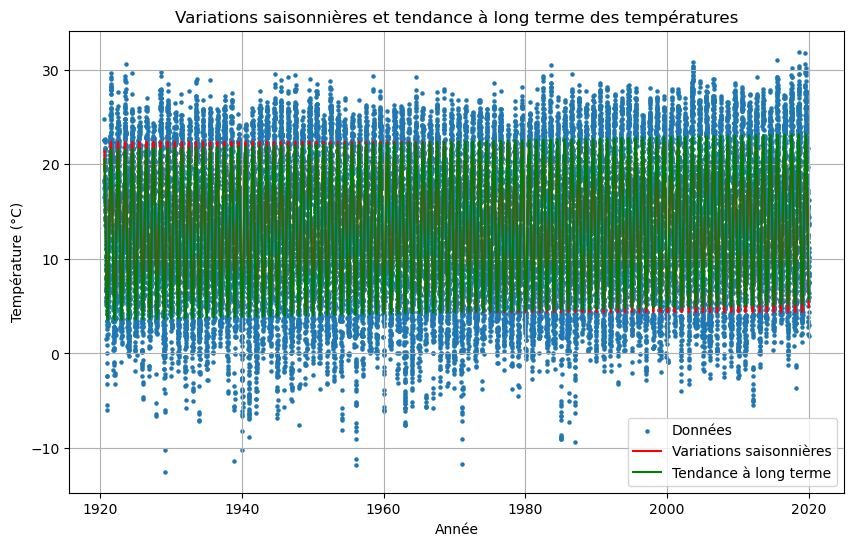

In [52]:
# Tracé des résultats

plt.figure(figsize=(10, 6))
plt.scatter(date_annee, temperature, s=5, label='Données')
plt.plot(date_annee, modele_saison(date_annee, *popt_seasonal), color='red', label='Variations saisonnières')
plt.plot(date_annee, modele_lin(date_annee, *popt_trend), color='green', label='Tendance à long terme')
plt.xlabel('Année')
plt.ylabel('Température (°C)')
plt.title('Variations saisonnières et tendance à long terme des températures')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Affichage du paramètre ajusté
print("Paramètres ajustés pour la tendance à long terme :", popt_trend)

Paramètres ajustés pour la tendance à long terme : [ 9.00923657e+00  6.28314829e+00 -1.79675146e+00 -1.98525928e+01
  1.68608037e-02]


In [60]:
incertitude_saison = np.sqrt(np.diag(pcov_seasonal))
incertitude_lin = np.sqrt(np.diag(pcov_trend))

print("Incertitude sur les paramètres du modèle saisonnier:", incertitude_saison)
print("Incertitude sur les paramètres du modèle linéaire:", incertitude_lin)


Incertitude sur les paramètres du modèle saisonnier: [2.38839836e-02 9.21796929e-05 1.81635056e-01 1.68786502e-02]
Incertitude sur les paramètres du modèle linéaire: [2.36126389e-02 9.11608281e-05 1.79632723e-01 1.14631531e+00
 5.81733576e-04]


Les ajustements ainsi que les incertitudes sont très faibles, de plus, on constate que la tendance à long terme est très proches des variations saisonnières. On a très peu d'erreurs car ils sont presques identiques. Alors le réchauffement observé est statistiquement significatif à ce niveau de confiance.